# Assignment 1

## Data inspection

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil
from collections.abc import Sequence
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
df = pd.read_csv("dataset_mood_smartphone.csv", index_col=0, parse_dates=["time"])
df.head()

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00,mood,6.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0


In [3]:
df.groupby('variable', sort=False).value.describe()

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
mood,5641.0,6.992555,1.032769,1.000,7.00000,7.000000,8.000000,10.000
circumplex.arousal,5597.0,-0.098624,1.051868,-2.000,-1.00000,0.000000,1.000000,2.000
circumplex.valence,5487.0,0.687808,0.671298,-2.000,0.00000,1.000000,1.000000,2.000
activity,22965.0,0.115958,0.186946,0.000,0.00000,0.021739,0.158333,1.000
screen,96578.0,75.335206,253.822497,0.035,5.32225,20.044500,62.540250,9867.007
call,5239.0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
sms,1798.0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
appCat.builtin,91288.0,18.538262,415.989243,-82798.871,2.02000,4.038000,9.922000,33960.246
appCat.communication,74276.0,43.343792,128.912750,0.006,5.21800,16.225500,45.475750,9830.777


In [4]:
# Number of different individuals and the overview statistics for the number of entries
df.groupby('id').count().time.describe()

count       27.000000
mean     13959.703704
std       5118.453040
min       2848.000000
25%      11295.000000
50%      14581.000000
75%      17295.000000
max      21999.000000
Name: time, dtype: float64

In [5]:
df.isnull().any()

id          False
time        False
variable    False
value        True
dtype: bool

In [6]:
df[df.isnull().value].variable.unique()

array(['circumplex.arousal', 'circumplex.valence'], dtype=object)

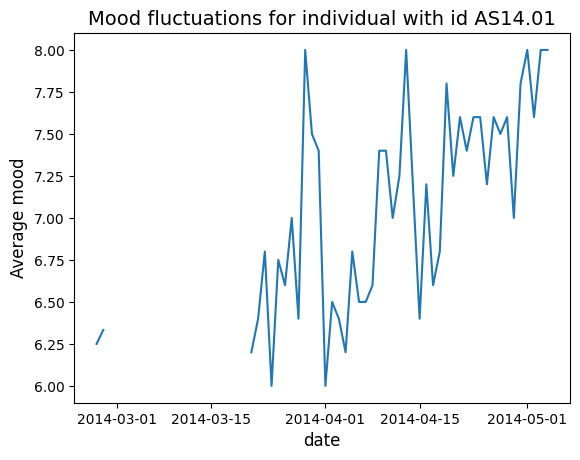

In [7]:
df['date'] = df.time.dt.date
moods = df.groupby(['id', 'date']).apply(lambda x: x[x.variable == 'mood'].value.mean(), include_groups=False)
for ID in df.id.unique():
    moods.loc[ID].plot()
    plt.ylabel("Average mood", fontsize=12)
    plt.xlabel("date", fontsize=12)
    plt.title(f"Mood fluctuations for individual with id {ID}", fontsize=14)
    # plt.savefig('images/mood.png')
    plt.show()
    break

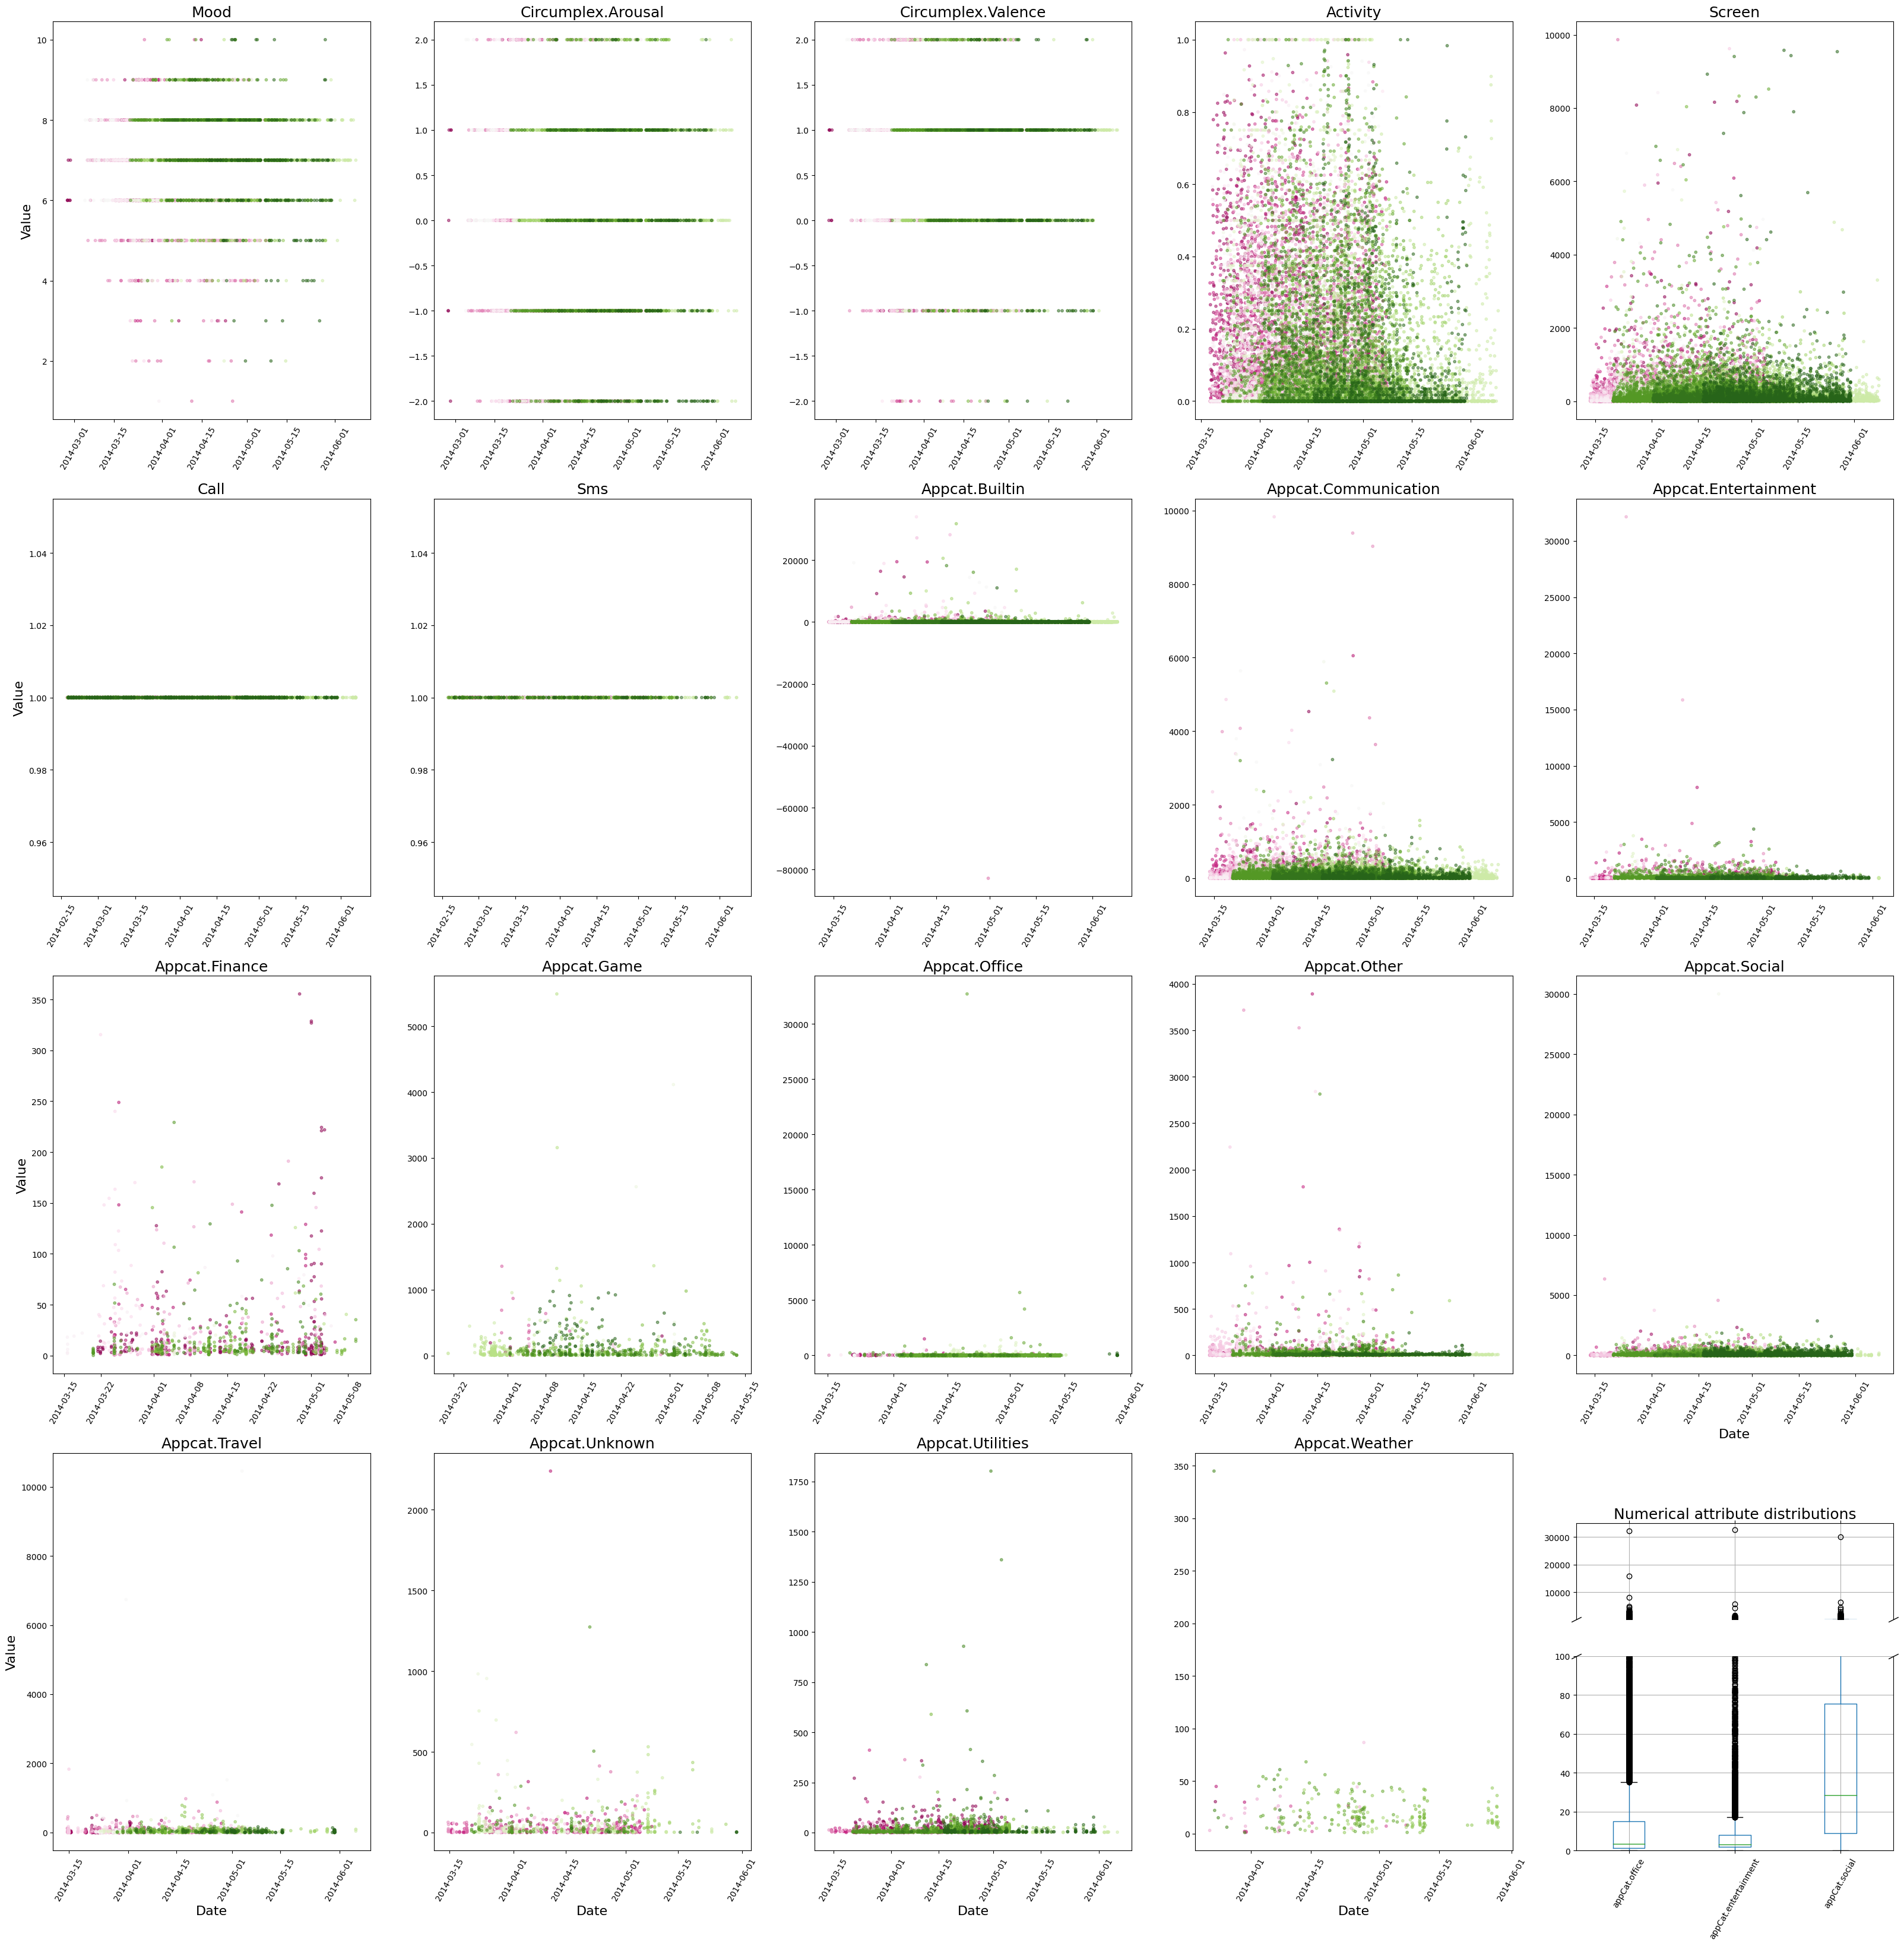

In [8]:
# Distributions of the variables color coded for different individuals
enc = LabelEncoder()
enc.fit(df.id.unique())

fig = plt.figure(figsize=(40, 40))
for i, var in enumerate(df.variable.unique()):
    ax = fig.add_subplot(4, 5, i+1)
    df[df.variable==var].plot(x='time', y='value', kind='scatter', ax=ax,
                              c=enc.transform(df[df.variable==var].id),
                              cmap='PiYG', alpha=0.5, s=10, colorbar=False)
    ax.set_title(var.title(), fontsize=18)
    ax.set_xlabel("Date", fontsize=16)
    ax.set_ylabel("Value", fontsize=16)
    if i < 14: ax.xaxis.label.set_visible(False)
    if i % 5 != 0: ax.yaxis.label.set_visible(False)
    ax.tick_params('x', labelrotation=60)

# Add some boxplots
kwargs = dict(marker=[(-1, -.5), (1, .5)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax = fig.add_subplot(8, 5, 40)
selection = df[df.variable.isin(["appCat.office", "appCat.entertainment", "appCat.social"])]
selection.groupby('variable').boxplot(subplots=False, ax=ax)
ax.tick_params('x', labelrotation=60)
ax.set_ylabel("Value", fontsize=16)
ax.set_ylim(0, 100)
ax.set_xticklabels(["appCat.office", "appCat.entertainment", "appCat.social"])
ax.spines.top.set_visible(False)
ax.xaxis.tick_bottom()
ax.plot([0, 1], [1, 1], transform=ax.transAxes, **kwargs)
ax.yaxis.label.set_visible(False)
ax = fig.add_subplot(16, 5, 70)
selection.groupby('variable').boxplot(subplots=False, ax=ax, sharex=ax)
ax.set_ylim(100, 35000)
ax.xaxis.label.set_visible(False)
ax.set_title("Numerical attribute distributions", fontsize=18)
ax.spines.bottom.set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)
ax.plot([0, 1], [0, 0], transform=ax.transAxes, **kwargs)
# plt.savefig("images/distributions.png")
plt.show()

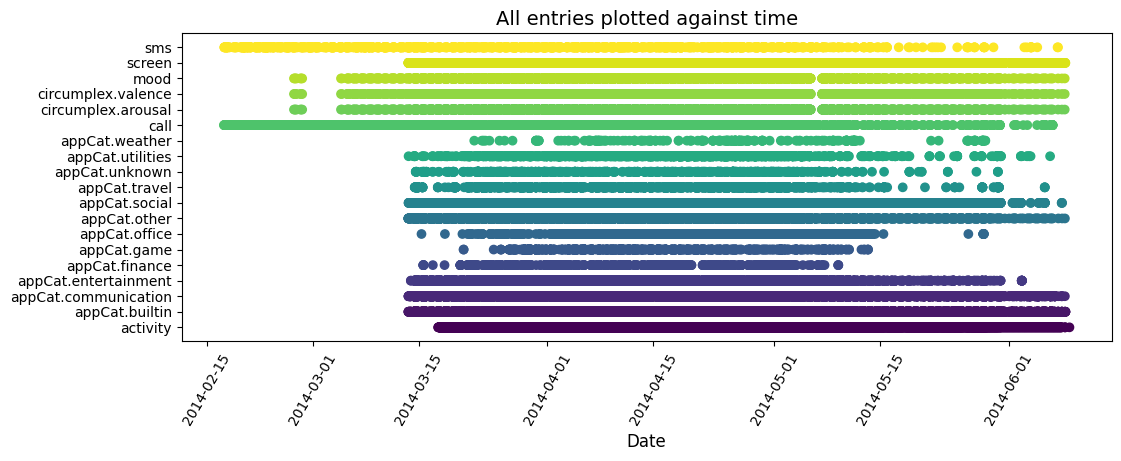

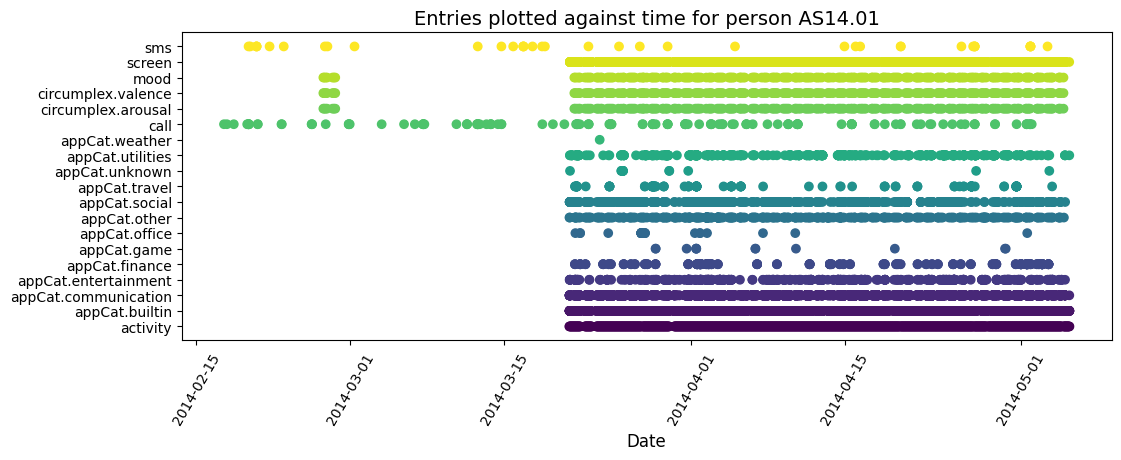

In [9]:
enc = LabelEncoder()
enc.fit(df.variable.unique())

def time_series(df, title=None):
    act = enc.transform(df.variable)
    plt.figure(figsize=(12, 4))
    plt.scatter(df.time, act, c=act)
    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.xticks(rotation=60)
    plt.yticks(range(len(enc.classes_)), enc.inverse_transform(range(len(enc.classes_))))
    # plt.tight_layout()
    # plt.savefig("images/timeseries_all.png")
    plt.show()

time_series(df, title=f"All entries plotted against time")
for ID in df.id.unique():
    time_series(df[df.id == ID], title=f"Entries plotted against time for person {ID}")
    break

## Data preprocessing

#### Removing erroneous values

In [10]:
df = pd.read_csv("dataset_mood_smartphone.csv", index_col=0, parse_dates=["time"])

unclean = """screen
appCat.builtin
appCat.communication
appCat.entertainment
appCat.finance
appCat.game
appCat.office
appCat.other
appCat.social
appCat.travel
appCat.unknown
appCat.utilities
appCat.weather""".split('\n')

df = df.drop(index=df[df.variable=='appCat.office'].value.idxmax()) # Drop extreme value

unclean = df[df.variable.isin(unclean)]
outliers = unclean.groupby('variable').apply( # Select outliers, values more than 3 std from the mean
    lambda x: x.value.abs() > x.value.mean() + 3 * x.value.std(),
    include_groups=False)

df = df.drop(index=unclean[unclean.value < 0].index) # Drop all negative values
df = df.drop(index=outliers[outliers.values].index.get_level_values(1), errors='ignore') # drop outliers
df = df.dropna()

#### Wrangling data into a format fit for training

In [11]:
# Rounding the timestamps to the nearest 30 minutes
# and splitting dates into days and hours
df['time'] = df.time.dt.round('30min')
df['date'] = df.time.dt.date
df['time'] = df.time.dt.time

In [12]:
# Aggregate numerical and ordinal values differently
df = df.groupby(['id', 'date', 'time', 'variable']).aggregate(['sum', 'mean']).reset_index()
rows = df.variable.isin(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity'])
df.loc[rows, ('value', 'sum')] = df[rows][('value', 'mean')]
df = df.drop(('value', 'mean'), axis=1)
df.columns = df.columns.droplevel(1)

In [13]:
# Converting the variables into columns to create timestamped feature vectors
data = pd.pivot_table(df, values=['value'], index=['id', 'date', 'time'], columns='variable', sort=False)
data = data.fillna(0)
data.columns = data.columns.droplevel()
data = data.reset_index(2)

# Convert time to float, i.e., 00:00 -> 1/48 and 23:30 -> 1
data['time'] = data.time.map(lambda x: (2 * x.hour + x.minute / 30 + 1) / 48)

# Add column to indicate days with no entries
data['missing'] = 0
data.head()

variable                time  call  sms  circumplex.arousal  \
id      date                                                  
AS14.01 2014-02-17  0.520833   1.0  0.0                 0.0   
        2014-02-17  0.791667   1.0  0.0                 0.0   
        2014-02-18  0.416667   1.0  0.0                 0.0   
        2014-02-19  0.625000   1.0  0.0                 0.0   
        2014-02-19  0.750000   4.0  1.0                 0.0   

variable            circumplex.valence  mood  activity  appCat.builtin  \
id      date                                                             
AS14.01 2014-02-17                 0.0   0.0       0.0             0.0   
        2014-02-17                 0.0   0.0       0.0             0.0   
        2014-02-18                 0.0   0.0       0.0             0.0   
        2014-02-19                 0.0   0.0       0.0             0.0   
        2014-02-19                 0.0   0.0       0.0             0.0   

variable            appCat.communication  appCat.entertainment  ...  \
id      date                                                    ...   
AS14.01 2014-02-17                   0.0                   0.0  ...   
        2014-02-17                   0.0                   0.0  ...   
        2014-02-18                   0.0                   0.0  ...   
        2014-02-19                   0.0                   0.0  ...   
        2014-02-19                   0.0                   0.0  ...   

variable            appCat.social  screen  appCat.unknown  appCat.utilities  \
id      date                                                                  
AS14.01 2014-02-17            0.0     0.0             0.0               0.0   
        2014-02-17            0.0     0.0             0.0               0.0   
        2014-02-18            0.0     0.0             0.0               0.0   
        2014-02-19            0.0     0.0             0.0               0.0   
        2014-02-19            0.0     0.0             0.0               0.0   

variable            appCat.finance  appCat.travel  appCat.office  \
id      date                                                       
AS14.01 2014-02-17             0.0            0.0            0.0   
        2014-02-17             0.0            0.0            0.0   
        2014-02-18             0.0            0.0            0.0   
        2014-02-19             0.0            0.0            0.0   
        2014-02-19             0.0            0.0            0.0   

variable            appCat.weather  appCat.game  missing  
id      date                                              
AS14.01 2014-02-17             0.0          0.0        0  
        2014-02-17             0.0          0.0        0  
        2014-02-18             0.0          0.0        0  
        2014-02-19             0.0          0.0        0  
        2014-02-19             0.0          0.0        0  

[5 rows x 21 columns]

#### Adding missing day rows
*Do not run the following cell twice*

In [14]:
# Get the first and last day of entries per person
min_ = data.groupby(level=0).apply(lambda x: x.index.get_level_values(1).min().strftime('%Y-%m-%d'))
max_ = data.groupby(level=0).apply(lambda x: x.index.get_level_values(1).max().strftime('%Y-%m-%d'))

# Find the set of all days and take the difference the days in the dataset to get the missing dates 
all_dates = {(i, date.date()) for (i, mn), mx in zip(min_.items(), max_) for date in pd.date_range(mn, mx, freq='D')}
missing_dates = pd.MultiIndex.from_tuples(all_dates.difference(set(data.index)))

# Create feature vectors for missing days with all values 0 except with 1 for the missing column
missing = pd.DataFrame([[0] * (len(data.columns) - 1) + [1]], index=missing_dates, columns=data.columns)
data = pd.concat([data, missing])

In [15]:
# The NaN values indicate no entries on mood that day and will be handled during training
mean_moods = data.groupby(level=[0, 1]).apply(lambda x: x[x.mood > 0].mood.mean())
mean_moods.head()

AS14.01  2014-02-17   NaN
         2014-02-18   NaN
         2014-02-19   NaN
         2014-02-20   NaN
         2014-02-21   NaN
dtype: float64

#### Padding features and labels
*Do not run these cells twice*

In [16]:
# Prepend a missing day x_0 for each individual to help predict y_1
padding = list(zip(min_.index, (pd.to_datetime(min_) - pd.Timedelta(days=1)).dt.date))
padding = pd.DataFrame([[0] * (len(data.columns) - 1) + [1]], index=padding, columns=data.columns)
data = pd.concat([data, padding])

data_svm = data.copy()

In [17]:
# Similarly append a missing average mood y_{t+1} for comparing with the predictions of x_t
padding = list(zip(max_.index, (pd.to_datetime(max_) + pd.Timedelta(days=1)).dt.date))
mean_moods = pd.concat([mean_moods, pd.Series(np.nan, index=padding)])

#### Creating an ML dataset

In [18]:
data = data.groupby(level=[0, 1]).apply(lambda x: x.to_numpy())
labels = mean_moods.groupby(level=0).apply(lambda x: x.to_numpy())

# Check to ensure that days are arranged in increasing order
data.index.is_monotonic_increasing and labels.index.is_monotonic_increasing

True

In [19]:
# Ragged array which roughly contains the data in the right format
# Segmenting and batching it will make the training much more efficient
data = data.groupby(level=0).apply(lambda x: x.to_numpy()).to_numpy()
labels = labels.to_numpy()

In [20]:
seq_len = 32

# For each individual, the last 10 days are split for testing
x_train, x_test, y_train, y_test = [], [], [], []
for x, y in zip(data, labels):
    x_train.append(x[:-10])
    y_train.append(y[:-10])
    x_test.append(x[-seq_len-9:])
    y_test.append(y[-seq_len-9:])

In [21]:
class Dataset(Sequence):
    def __init__(self, features, labels, seq_len=16, batch_size=16):
        self.sl = seq_len
        self.bs = batch_size
        longest = max([d.shape[0] for i in features for d in i])
        
        # Segment and pad the data to fit into a PyTorch tensor
        self.data = torch.tensor(np.asarray([[
            self.pad(ind[j], (longest - ind[j].shape[0]))
            for j in range(i, i + seq_len)]
            for ind in features
            for i in range(len(ind) - seq_len + 1)
        ]), device=device, dtype=torch.float32)
        
        self.labels = torch.tensor(np.asarray([
            l[i:i + seq_len] for l in labels
            for i in range(len(l) - seq_len + 1)
        ]), device=device, dtype=torch.float32)
    
    def __len__(self):
        return ceil(self.data.shape[0] / self.bs)
    
    def __getitem__(self, i):
        if i >= len(self): raise IndexError("list index out of range")
        return self.data[i*self.bs:(i+1)*self.bs], self.labels[i*self.bs:(i+1)*self.bs]
    
    def __repr__(self):
        return f"Dataset with X.shape={tuple(self.data.shape)} and y.shape={tuple(self.labels.shape)}"
    
    def pad(self, arr, pad):
        return np.vstack([arr, [[np.nan] * arr.shape[1]] * pad]) if pad > 0 else arr
    
    def shuffle(self):
        idx = np.random.permutation(range(self.data.shape[0]))
        self.data = self.data[idx]
        self.labels = self.labels[idx]

In [22]:
d = Dataset(x_train, y_train, seq_len=seq_len, batch_size=32)
d

Dataset with X.shape=(1074, 32, 44, 21) and y.shape=(1074, 32)

## Building the Neural Network

In [23]:
def PWFFN(inp, out, hidden=None):
    hidden = 4 * inp if hidden is None else hidden
    return nn.Sequential(nn.Linear(inp, hidden), nn.ReLU(), nn.Linear(hidden, out))


class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=1):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.norm = nn.LayerNorm(dim)
        self.lin = PWFFN(dim, dim)
    
    def get_masks(self, nan):
        # Returns the key embedding and the attention masks
        attn_mask = (~nan).to(torch.float) @ (~nan).swapaxes(1, -1).to(torch.float) == 0
        return nan.any(dim=-1), attn_mask.repeat_interleave(self.attn.num_heads, dim=0)
    
    def forward(self, x, nan):
        key_mask, attn_mask = self.get_masks(nan)
        # MASKING DOES NOT WORK WITH BACKPROPAGATION IN PYTORCH
        # LEAVE PADDING AS 0s AND HOPE FOR THE BEST
        y, _ = self.attn(x, x, x)#, key_padding_mask=key_mask, attn_mask=attn_mask)
        y = self.norm(y.nan_to_num(0) + x)
        y = self.norm(self.lin(y) + y)
        return y

    
class ARNetwork(nn.Module):
    def __init__(self, features, enc=32, heads=4, transformer_blocks=6, lstm=128, regression=True):
        super().__init__()
        self.enc = enc
        self.regression = regression
        self.encoding = PWFFN(features, enc, enc * 4)
        self.transformers = [TransformerBlock(enc, heads=heads) for _ in range(transformer_blocks)]
        for i, t in enumerate(self.transformers):
            self.add_module(f"transformer{i}", t)
        self.lstm = nn.LSTM(enc, lstm, batch_first=True)
        self.lin = nn.Linear(lstm, 1 if regression else 10)
    
    def global_average(self, x, daily_entries):
        return x.nan_to_num(0).sum(dim=-2) / daily_entries
    
    def forward(self, x):
        bs, days, entries, features = x.shape
        nan = x.isnan()
        daily_entries = (~nan.any(dim=-1)).sum(dim=-1).view(-1, days, 1)
        
        x = self.encoding(x.nan_to_num(0))
        x = x.reshape(-1, entries, self.enc)
        x, nan = x.reshape(-1, entries, self.enc), nan.reshape(-1, entries, features)
        for trans in self.transformers:
            x = trans(x, nan)
        x = self.global_average(x.reshape(bs, days, entries, -1), daily_entries)
        x, _ = self.lstm(x)
        x = self.lin(x).squeeze()
        return 10 * nn.functional.sigmoid(x) if self.regression else nn.functional.softmax(x, dim=1)

In [24]:
net = ARNetwork(d[0][0].shape[-1], regression=True).to(device)
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=3e-5, weight_decay=1e-4)

In [25]:
EPOCHS = 25

b_losses, accuracies = list(), list()
net.train
for i in range(EPOCHS):
    d.shuffle()
    losses = list()
    preds, reals = torch.tensor([], device=device), torch.tensor([], device=device)
    for x, y in tqdm(d):
        optimizer.zero_grad()
        pred = net(x)[~y.isnan()]
        y = y[~y.isnan()]
        if not net.regression:
            y = y.round().type(torch.long) - 1
            preds = torch.concat([preds, pred.argmax(-1)])
            reals = torch.concat([reals, y])
        loss = criterion(pred, y)
        loss.backward()
        nn.utils.clip_grad_norm_([p for p in net.parameters() if p.requires_grad], 0.05)
        optimizer.step()
        losses.append(loss.detach().cpu())
    b_losses.append(sum(losses) / len(losses))
    if not net.regression:
        accuracies.append((preds == reals).sum().detach().cpu() / reals.shape[0])
        print(f"Accuracy: {accuracies[-1]:.2}")

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:05<00:00,  5.86it/s]


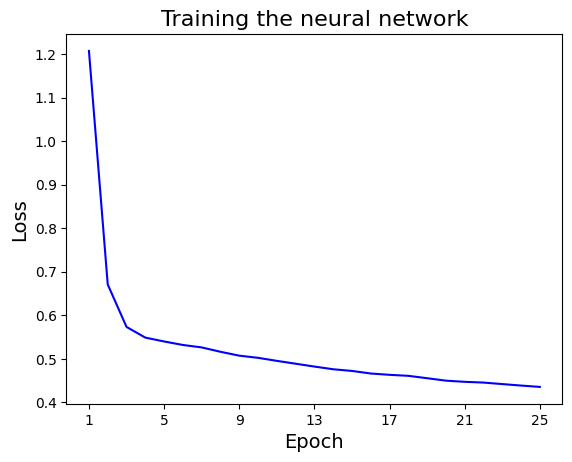

In [26]:
if net.regression:
    plt.plot(range(1, EPOCHS + 1), b_losses, c='b')
    plt.title("Training the neural network", fontsize=16)
    plt.ylabel("Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.xticks(range(1, EPOCHS + 1, 4))
    plt.savefig('images/training_r.png')
else:
    _, ax = plt.subplots()
    ax.plot(range(1, EPOCHS + 1), b_losses, c='b')
    ax.set_ylabel("Loss", c='b', fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    ax = ax.twinx()
    ax.plot(range(1, EPOCHS + 1), accuracies, c='r')
    ax.axline((1, 0.1), slope=0, c='gray', linestyle='--')
    ax.set_ylim(0.08, max(accuracies) + 0.05)
    ax.set_ylabel("Accuracy", c='r', fontsize=14)
    plt.title("Training the neural network", fontsize=16)
    plt.xticks(range(1, EPOCHS + 1, 4))
    plt.savefig('images/training_c.png')
plt.show()

In [27]:
d = Dataset(x_test, y_test, seq_len=seq_len, batch_size=270)
d

Dataset with X.shape=(270, 32, 44, 21) and y.shape=(270, 32)

In [28]:
x, y = d[0]
pred = net(x)
if net.regression:
    # Regression testing statistic
    print(mean_squared_error(y[~y.isnan()].cpu().detach(), pred[~y.isnan()].cpu().detach()))
    print(mean_absolute_error(y[~y.isnan()].cpu().detach(), pred[~y.isnan()].cpu().detach()))
else:
    # Classification testing statistics
    print(classification_report(y[~y.isnan()].round().cpu(), pred.argmax(-1)[~y.isnan()].cpu() + 1, zero_division=0))

0.48614883
0.507987


## Using SVMs

In [29]:
df = pd.read_csv("dataset_mood_smartphone.csv", index_col=0, parse_dates=["time"])

unclean = """screen
appCat.builtin
appCat.communication
appCat.entertainment
appCat.finance
appCat.game
appCat.office
appCat.other
appCat.social
appCat.travel
appCat.unknown
appCat.utilities
appCat.weather""".split('\n')

df = df.drop(index=df[df.variable=='appCat.office'].value.idxmax()) # Drop extreme value

unclean = df[df.variable.isin(unclean)]
outliers = unclean.groupby('variable').apply( # Select outliers, values more than 3 std from the mean
    lambda x: x.value.abs() > x.value.mean() + 3 * x.value.std(),
    include_groups=False)

df = df.drop(index=unclean[unclean.value < 0].index) # Drop all negative values
df = df.drop(index=outliers[outliers.values].index.get_level_values(1), errors='ignore') # drop outliers
df = df.dropna()

In [30]:
df['date'] = df.time
df['time'] = df.time.dt.time.map(lambda x: (2 * x.hour + x.minute / 30 + 1) / 48)

df['g'] = df.groupby('variable').cumcount()
df = df.set_index(['g', 'id', 'date', 'time', 'variable']).stack().unstack([-2, -1]).reset_index(0, drop=True)
df.columns = df.columns.droplevel(1)
df = df.reset_index([1, 2]).fillna(0)

df['missing'] = 0
df['date'] = df.date.dt.date
df = df.set_index('date', append=True)

In [31]:
# Get the first and last day of entries per person
min_ = df.groupby(level=0).apply(lambda x: x.index.get_level_values(1).min().strftime('%Y-%m-%d'))
max_ = df.groupby(level=0).apply(lambda x: x.index.get_level_values(1).max().strftime('%Y-%m-%d'))

# Find the set of all days and take the difference the days in the dataset to get the missing dates 
all_dates = {(i, date.date()) for (i, mn), mx in zip(min_.items(), max_) for date in pd.date_range(mn, mx, freq='D')}
missing_dates = pd.MultiIndex.from_tuples(all_dates.difference(set(df.index)))

# Create feature vectors for missing days with all values 0 except with 1 for the missing column
missing = pd.DataFrame([[0] * (len(df.columns) - 1) + [1]], index=missing_dates, columns=df.columns)
df = pd.concat([df, missing])

In [32]:
# The NaN values indicate no entries on mood that day and will be handled during training
mean_moods = df.groupby(level=[0, 1]).apply(lambda x: x[x.mood > 0].mood.mean())
mean_moods.head()

AS14.01  2014-02-17   NaN
         2014-02-18   NaN
         2014-02-19   NaN
         2014-02-20   NaN
         2014-02-21   NaN
dtype: float64

In [33]:
# Prepend a missing day x_0 for each individual to help predict y_1
padding = list(zip(min_.index, (pd.to_datetime(min_) - pd.Timedelta(days=1)).dt.date))
padding = pd.DataFrame([[0] * (len(df.columns) - 1) + [1]], index=padding, columns=df.columns)
df = pd.concat([df, padding])

In [34]:
# Similarly append a missing average mood y_{t+1} for comparing with the predictions of x_t
padding = list(zip(max_.index, (pd.to_datetime(max_) + pd.Timedelta(days=1)).dt.date))
mean_moods = pd.concat([mean_moods, pd.Series(np.nan, index=padding)])

In [35]:
# Select different aggregation functions for the different features
nonzero_mean = lambda x: x.sum() / x[x != 0].count() if x.sum() > 0 else -10
agg = {k: 'sum' for k in data_svm.columns}
for k in ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']:
    agg[k] = nonzero_mean
agg['time'] = ['min', 'median', 'max']

data = df.groupby(level=[0, 1]).aggregate(agg)

data.iloc[:,9:-1] = np.log(data.iloc[:,9:-1]).replace([np.inf, -np.inf], 0)

D:\Python\Python 3.11\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [36]:
data = data.groupby(level=[0, 1]).apply(lambda x: x.to_numpy().squeeze())
labels = mean_moods.groupby(level=0).apply(lambda x: x.to_numpy())

# Check to ensure that days are arranged in increasing order
data.index.is_monotonic_increasing and labels.index.is_monotonic_increasing

True

In [37]:
data = data.groupby(level=0).apply(lambda x: x.to_numpy()).to_numpy()
labels = labels.to_numpy()

In [38]:
seq_length = 8

x_train, x_test, y_train, y_test = [], [], [], []
for x, y in zip(data, labels):
    x_train.append(x[:-10])
    y_train.append(y[:-10])
    x_test.append(x[-seq_length-9:])
    y_test.append(y[-seq_length-9:])

In [39]:
def data_prep(features, labels):
    data = list()
    for x, y in zip(features, labels):
        x = np.hstack([np.vstack(x), y.reshape(-1, 1)])[~np.isnan(y)]
        for i in range(len(x) - seq_length):
            data.append(x[i:i + seq_length])
    y = np.asarray(data)[:,-1,-1]
    x = np.asarray(data)[:,:,:-1].reshape(len(y), -1)
    return x, y

In [40]:
x, y = data_prep(x_train, y_train)
svm = GridSearchCV(SVR(), param_grid={'C': np.logspace(-2, 2, 5)}, scoring='neg_mean_squared_error')
svm.fit(x, y)
x, y = data_prep(x_test, y_test)
print(svm.best_params_)
svm = svm.best_estimator_
mean_squared_error(y, svm.predict(x))

{'C': 0.1}


0.5013825143057612

In [41]:
x, y = data_prep(x_train, y_train)
svm = GridSearchCV(SVC(), param_grid={'C': np.logspace(-2, 2, 5)}, scoring='f1_weighted')
svm.fit(x, y.round())
print(svm.best_params_)
svm = svm.best_estimator_
x, y = data_prep(x_test, y_test)
print(classification_report(y.round(), svm.predict(x), zero_division=0))
# print(pd.DataFrame(classification_report(y.round(), svm.predict(x), zero_division=0, output_dict=True)).T.to_latex(float_format='%.2f'))

D:\Python\Python 3.11\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{'C': 1.0}
              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00        39
         7.0       0.53      0.98      0.69        97
         8.0       0.85      0.23      0.37        47
         9.0       0.00      0.00      0.00         1

    accuracy                           0.55       191
   macro avg       0.28      0.24      0.21       191
weighted avg       0.48      0.55      0.44       191

